In [1]:
# import libs and config stuff
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


## Torchvision
import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import layers


<ipython-input-1-65c6a9fafad7>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [2]:
BATCH_SIZE = 1
img_size = 72

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path


train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing



download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

In [3]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(img_size, img_size),
                                               class_mode='categorical',
                                               classes=class_subset,
                                              #  subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=False,
                                               seed=42)

validgen = train_generator.flow_from_directory(val_data_dir,
                                               target_size=(img_size, img_size),
                                               class_mode='categorical',
                                               classes=class_subset,
                                              #  subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [4]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    # model.compile(
    #     optimizer=optimizer,
    #     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #     metrics=[
    #         keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    #         keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    #     ],
    # )
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [5]:
input_shape = (72, 72, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=7

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [8]:
def run_experiment(model):
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=30,#n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint_callback])
    return history

history = run_experiment(vgg_model)

Epoch 1/30
280/280 [==============================] - 67s 210ms/step - loss: 14.7596 - accuracy: 0.4714 - val_loss: 3.2410 - val_accuracy: 0.6857
Epoch 2/30
280/280 [==============================] - 54s 193ms/step - loss: 6.1418 - accuracy: 0.5643 - val_loss: 3.4256 - val_accuracy: 0.6286
Epoch 3/30
280/280 [==============================] - 53s 189ms/step - loss: 4.2289 - accuracy: 0.6964 - val_loss: 1.6545 - val_accuracy: 0.7429
Epoch 4/30
280/280 [==============================] - 56s 201ms/step - loss: 3.4745 - accuracy: 0.6214 - val_loss: 3.7904 - val_accuracy: 0.7143
Epoch 5/30
280/280 [==============================] - 53s 189ms/step - loss: 2.0465 - accuracy: 0.6857 - val_loss: 3.0105 - val_accuracy: 0.7429
Epoch 6/30
280/280 [==============================] - 65s 233ms/step - loss: 2.0026 - accuracy: 0.7143 - val_loss: 1.8709 - val_accuracy: 0.7429
Epoch 7/30
280/280 [==============================] - 54s 192ms/step - loss: 1.0084 - accuracy: 0.7821 - val_loss: 3.9231 - val_a

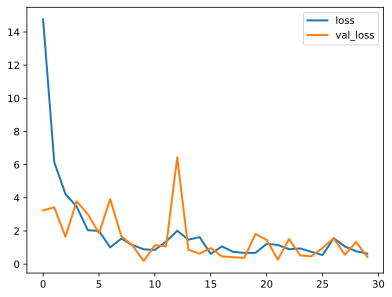

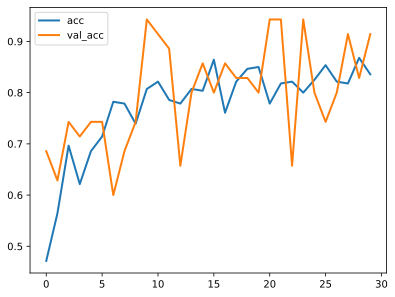

In [9]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

35/35 [==============================] - 6s 167ms/step
Precisão: 0.9714285714285714


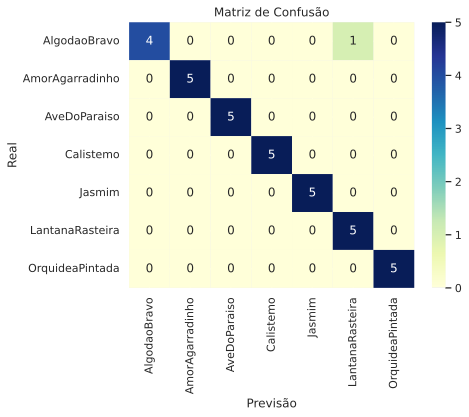

In [14]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = vgg_model.predict(validgen)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = validgen.classes

# Obter os nomes das classes
class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [22]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = validgen.classes

# Obter os nomes das classes
class_names = list(validgen.class_indices.keys())

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Exibir o relatório de classificação
print(report)


                 precision    recall  f1-score   support

   AlgodaoBravo       1.00      0.60      0.75         5
AmorAgarradinho       0.71      1.00      0.83         5
   AveDoParaiso       1.00      0.80      0.89         5
      Calistemo       1.00      0.60      0.75         5
         Jasmim       1.00      1.00      1.00         5
LantanaRasteira       0.83      1.00      0.91         5
OrquideaPintada       0.71      1.00      0.83         5

       accuracy                           0.86        35
      macro avg       0.89      0.86      0.85        35
   weighted avg       0.89      0.86      0.85        35



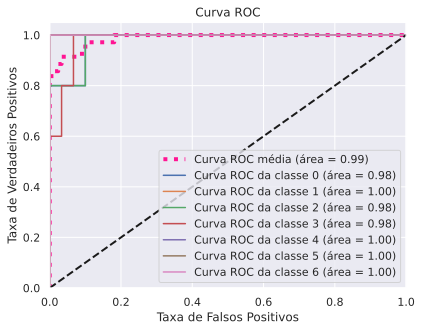

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Converter os rótulos verdadeiros em um formato binarizado
n_classes = len(validgen.class_indices)
true_classes_bin = label_binarize(true_classes, classes=list(range(n_classes)))

# Calcular a curva ROC para cada classe usando a estratégia "one-vs-all"
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular a curva ROC média usando a estratégia "one-vs-all"
fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar as curvas ROC
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Curva ROC média (área = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Curva ROC da classe {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
